In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Welcome to my Gaussian Process Regression tutorial notebook!

We'll be looking at a simplistic Gaussian process regression (GPR). The following is based on freely available material, namely a tutorial by [M. Ebden](https://arxiv.org/pdf/1505.02965.pdf) with some additional theoretical backing from [Rasmussen and Williams (2006)](http://www.gaussianprocess.org/gpml/chapters/RW.pdf).

 1. Linear Model
 1. Feature Space and Programmable Expressions
 1. A Sample Regression

## 1. Linear Model

We will begin with a linear model $f({\bf x})$ modeling true values ${\bf y}$ with Gaussian noise $\epsilon \sim \mathcal{N}(0,\sigma_n^2)$:

$$f({\bf x}) = {\bf x}^T {\bf w},$$

$${\bf y} = f({\bf x}) + \epsilon.$$

From this we obtain a Gaussian likelihood with the mean of the linear model and variance of the noise,
$$p({\bf y}|{\bf X},{\bf w}) = \mathcal{N}({\bf X}^T{\bf w},\sigma_n^2{\bf I}).$$

Assuming the weights follow a Gaussian prior ${\bf w} \sim \mathcal{N}(0,\Sigma_p)$, the posteror distribution of the weights follow a product of the likelihood and prior distributions (which is also Gaussian):
$$p({\bf w}|{\bf X},{\bf y}) \sim \mathcal{N}({\bf w}=\sigma_n^{-2}{\bf A}^{-1}{\bf X}{\bf y},{\bf A}^{-1})$$

where

$${\bf A} = \sigma_n^{-2}{\bf X}{\bf X}^T + \Sigma_p^{-1}$$

using Bayes' Theorem and ignoring the marginal likelihood (which is independent of the weights). Finally, a predictive distribution for a new (test, as opposed to training) point ${\bf x_*}$ by integrating over all possible parameters weighted by their posterior probabilities,

$$p(f({\bf x}_*)|{\bf x}_*,{\bf X},{\bf y}) = \int p(f({\bf x}_*)|{\bf x}_*,{\bf w})p({\bf w}|{\bf X},{\bf y})d{\bf w}$$
$$ = \mathcal{N}(\sigma_n^{-2}{\bf x}_*^T{\bf A}^{-1}{\bf X}{\bf y},{\bf x}_*^T{\bf A}^{-1}{\bf x}_*).$$

This is why GPR is often considered a non-parametric method- while there are parameters which assume some distribution of the data, they are integrated out in this step. Another view is that GPR is "infinitely" parametric, meaning it considers all possible values of the parameters. This is only true theoretically in the limit of an infinitely-spanning prior distribution; in practice, the prior must be limited. 

## 2. Feature Space and Programmable Expressions

Now that we have a predictive distribution in the input space, we can lift our equations into a higher-dimensional feature space by replacing instances of ${\bf x}$ with basis functions ${\bf \phi}({\bf x})$: 

$$p(f({\bf x}_*)|{\bf x}_*,{\bf X},{\bf y}) = \mathcal{N}(\sigma_n^{-2}{\bf \phi}({\bf x}_*)^T{\bf A}^{-1}{\bf \Phi}{\bf y},\ {\bf \phi}({\bf x}_*)^T{\bf A}^{-1}{\bf \phi}({\bf x}_*))$$

where

$${\bf \Phi} = {\bf \phi}({\bf X}) \; ; \quad {\bf A} = \sigma_n^{-2}{\bf \Phi}{\bf \Phi}^T + \Sigma_p^{-1}.$$

The expensive part of this step is the inversion of the $N x N \;{\bf A}$ matrix, where $N$ is the number of features. This can be reduced by the introduction of a kernel matrix ${\bf K}$, which describes the _difference_ between two sets of features:

$$p(f({\bf x}_*)|{\bf x}_*,{\bf X},{\bf y}) = \mathcal{N}({\bf \phi}({\bf x}_*)^T{\bf \Sigma}_p{\bf \Phi}({\bf K} + \sigma_n^2{\bf I})^{-1}{\bf y}, \; {\bf \phi}({\bf x}_*)^T{\bf \Sigma}_p{\bf \phi}({\bf x}_*) - {\bf \phi}({\bf x}_*)^T{\bf \Sigma}_p{\bf \Phi}({\bf K} + \sigma_n^2{\bf I})^{-1}{\bf \Phi}{\bf \Sigma}_p{\bf \phi}({\bf x}_*))$$

where ${\bf K} = {\bf \Phi \Sigma}_p{\bf \Phi}$ and is of size $n x n$ where $n$ is the number of training points.

Before analyzing this distribution, it is helpful to introduce the simplifying notation:

$${\bf K}({\bf X},{\bf X}) \equiv {\bf K}\quad \textrm{"Training Kernel"}$$
$${\bf K}({\bf X},{\bf X}_*) \equiv {\bf K}_*\quad \textrm{"Overlap Kernel"}$$
$${\bf K}({\bf X}_*,{\bf X}_*) \equiv {\bf K}_{**}\quad \textrm{"Prediction Kernel"}$$

and equivalent definitions for the kernel vectors $\bf{k}$.

Now the mean and covariance of the above predictive distribution can be simplified, for a single predicted point ${\bf x}_*$,

$$\bar{f}_* = {\bf k}^T_*({\bf K} + \sigma_n^2{\bf I})^{-1}{\bf y}$$

$$var[\bar{f}_*] = k_{**} - {\bf k}^T_*({\bf K} + \sigma_n^2{\bf I})^{-1}{\bf k}_*.$$

Now the mean of the predictive distribution can be seen as a product of the overlap kernel vector with the inverse of the full (noisy) training kernel matrix, dotted with the training targets. The variance is simply the prediction kernel (which is a single value for a single test point) with a training kernel penalty weighted by the overlap kernel vector. 

These equations are the key predictive equations for Gaussian process regression. One need only determine the optimal parameters and compute the kernels using the training and test inputs. It should be noted that the determination of the optimal parameters is done by maximizing the negative log of the marginal likelihood (the likelihood times the prior) via some algorithm such as gradient descent, and will be ignored here. Note also that one must specify a kernel function, such as the popular radial basis function kernel used below. 

## 3. A Sample Regression

Our goal will be to find a mean fit and variance of the following function with noise using the above formulae.

We will utilize the popular radial basis function (rbf) kernel, modified by adding the noise term directly:

$$k(x,x') = \sigma_f^2 exp\left[\frac{-(x-x')^2}{2l^2}\right] + \sigma_n\delta(x,x').$$

This kernel has three hyperparameters: the fitting error $\sigma_f$, noise error $\sigma_n$, and length scale $l$. While inversion of this matrix will not be too difficult for our case, this positive-definite kernel allows for a Cholesky decomposition which can significantly reduce the computational expense of the inversion. Note that while the noise is generally kept separate from the kernel in GPR, its inclusion here simplifies our lives somewhat.

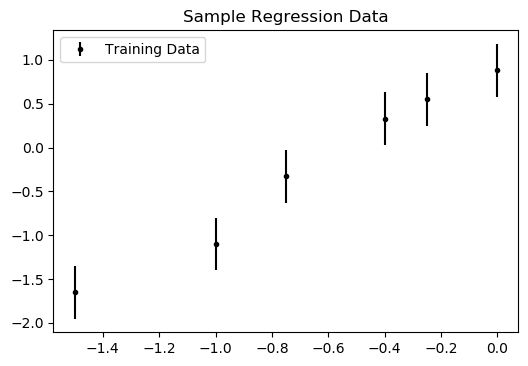

In [2]:
X = np.array([-1.50, -1.00, -0.75, -0.40, -0.25, 0.00])
y = np.array([-1.65, -1.10, -0.33, 0.33, 0.55, 0.88])
sn = 0.3

plt.figure(1,dpi=100)
plt.title("Sample Regression Data")
plt.errorbar(X,y,sn,fmt='k.',label="Training Data")
plt.legend(loc='upper left')
plt.show()

First, we will build a function which generates the rbf values. We will return individual elements and build the matrices ourselves.
For an individual point, it will suffice to build the training kernel matrix, the overlap kernel vector, and the prediction kernel value. We will use pre-optimized hyperparameter values for the purposes of this tutorial.

Once the kernels are built, the mean and variance can be predicted. The mean of the training targets will be set to 0 for the regression.

In [3]:
def rbf(x1,x2,sf=1,l=1,sn=0):
    """
    Generate the radial basis function (or "squared exponential") kernel.
    Pass scalars x1 and x2 and (optional) scalar hyperparameters."""
    if x1 == x2:
        d = 1
    else:
        d = 0
    return sf**2 * np.exp(-1 * np.linalg.norm(x1 - x2)**2 / (2.0 * l**2)) + sn**2 * d

In [4]:
# Optimized hypers courtesy of M. Ebden
sf = 1.27
l = 1.00

# Predict a single point
xs = 0.2

# Training kernel matrix
K = np.zeros((len(X),len(X)))
for i in range(0,len(X)):
    for j in range(0,len(X)):
        K[i][j] = rbf(X[i],X[j],sf,l,sn)

# Overlap kernel vector
Ks = np.asarray([rbf(xs,x,sf,l,sn) for x in X])

# Prediction kernel point
Kss = rbf(xs,xs,sf,l,sn)
print("K:\n{}\nK*:\n{}\nK**:\n{}".format(K,Ks,Kss))

K:
[[1.7029     1.42337925 1.21748079 0.88076344 0.73843943 0.52363196]
 [1.42337925 1.7029     1.56327628 1.34720732 1.21748079 0.9782733 ]
 [1.21748079 1.56327628 1.7029     1.51707449 1.42337925 1.21748079]
 [0.88076344 1.34720732 1.51707449 1.7029     1.59485656 1.48889436]
 [0.73843943 1.21748079 1.42337925 1.59485656 1.7029     1.56327628]
 [0.52363196 0.9782733  1.21748079 1.48889436 1.56327628 1.7029    ]]
K*:
[0.38023485 0.78508271 1.02714571 1.34720732 1.45758915 1.58096244]
K**:
1.7029


In [5]:
# Shift mean of training targets to 0
y_avg = np.mean(y)
y -= y_avg

# Predict the test target mean and variance, reform y
ys1 = np.dot(np.dot(Ks,np.linalg.inv(K)),y) + y_avg
var_ys1 = Kss - np.dot(np.dot(Ks,np.linalg.inv(K)),Ks.T)
y += y_avg

print("f({}) = {} +/- {}".format(xs,ys1,var_ys1**0.5))

f(0.2) = 0.9645305048593126 +/- 0.453921847344483


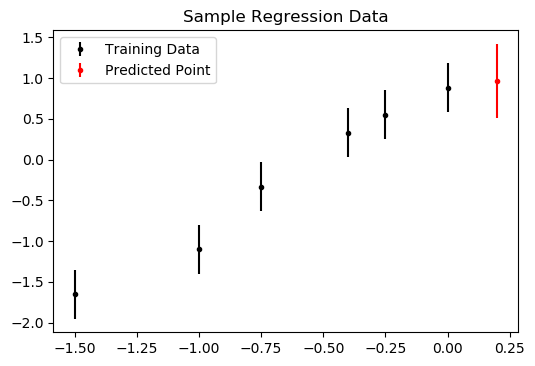

In [6]:
plt.figure(1,dpi=100)
plt.title("Sample Regression Data")
plt.errorbar(X,y,sn,fmt='k.',label="Training Data")
plt.errorbar(xs,ys1,var_ys1**0.5,fmt='r.',label="Predicted Point")
plt.legend(loc='upper left')
plt.show()

To calculate an entire distribution for ${\bf X}_*$, we simply calculate the full overlap and prediction kernels. Note that we will only use the diagonal of the prediction kernel, as we are only interested in the variance; however, the entire covariance matrix can be used as a metric in several related schemes.

Finally, we find the mean and variance of the predictive distribution using the mean-shifted training targets. Here we will plot the standard deviation as well as the 95% confidence interval in grey. 

In [7]:
# Entire distribution
Xs = np.linspace(-1.7,0.3,1000)

# Overlap kernel
Ks = np.zeros((len(Xs),len(X)))
for i in range(0,len(Xs)):
    for j in range(0,len(X)):
        Ks[i][j] = rbf(Xs[i],X[j],sf,l,sn)

# Prediction kernel
Kss = np.zeros((len(Xs),len(Xs)))
for i in range(0,len(Xs)):
    for j in range(0,len(Xs)):
        Kss[i][j] = rbf(Xs[i],Xs[j],sf,l,sn)

In [8]:
y -= y_avg
ys = np.asarray([np.dot(np.dot(Ks[i],np.linalg.inv(K)),y) for i in range(0,len(Xs))]) + y_avg
var_ys = [Kss[i][i] - np.dot(np.dot(Ks[i],np.linalg.inv(K)),Ks[i].T) for i in range(0,len(Xs))]
CI = [1.96 * var**0.5 for var in var_ys]
y += y_avg

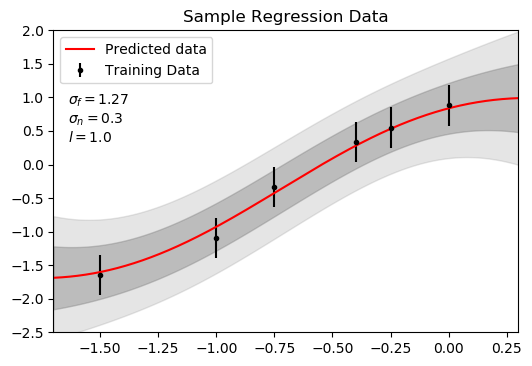

In [9]:
plt.figure(1,dpi=100)
plt.title("Sample Regression Data")
plt.errorbar(X,y,sn,fmt='k.',label="Training Data")
plt.plot(Xs,ys,'r',label="Predicted data")
plt.fill_between(Xs,ys-np.power(var_ys,0.5),ys+np.power(var_ys,0.5),color='gray',alpha=0.4)
plt.fill_between(Xs,ys-CI,ys+CI,color='gray',alpha=0.2)
plt.legend(loc='upper left')
plt.figtext(0.15,0.60,'$\sigma_f = {}$\n$\sigma_n = {}$\n$l = {}$'.format(sf,sn,l))
plt.axis([-1.7,0.3,-2.5,2])
plt.show()

The final mean distribution matches the training data well, and the 95% confidence interval is reasonable considering the noise in the inputs. As mentioned in the tutorial by Ebden, one could integrate over all possible parameter values (weighted by their posterior distribution) for a better fit. This procedure is mentioned in chapter 5 of Rasmussen and Williams.